In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr   
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math

/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [136]:
train = pd.read_csv('train.csv')
train  = train.rename(index=str, columns={"1stFlrSF": "FirstFlrSF", 
                                         '2ndFlrSF': 'SecondFlrSF'})
test = pd.read_csv('test.csv')
test  = test.rename(index=str, columns={"1stFlrSF": "FirstFlrSF", 
                                         '2ndFlrSF': 'SecondFlrSF'})
train['total_sf'] = train['FirstFlrSF'] + train['SecondFlrSF'] + train['GrLivArea'] 
test['total_sf'] = test['FirstFlrSF'] + test['SecondFlrSF'] + test['GrLivArea']

[Text(0,0,u'LotFrontage'),
 Text(0,0,u'Alley'),
 Text(0,0,u'MasVnrType'),
 Text(0,0,u'MasVnrArea'),
 Text(0,0,u'BsmtQual'),
 Text(0,0,u'BsmtCond'),
 Text(0,0,u'BsmtExposure'),
 Text(0,0,u'BsmtFinType1'),
 Text(0,0,u'BsmtFinType2'),
 Text(0,0,u'Electrical'),
 Text(0,0,u'FireplaceQu'),
 Text(0,0,u'GarageType'),
 Text(0,0,u'GarageYrBlt'),
 Text(0,0,u'GarageFinish'),
 Text(0,0,u'GarageQual'),
 Text(0,0,u'GarageCond'),
 Text(0,0,u'PoolQC'),
 Text(0,0,u'Fence'),
 Text(0,0,u'MiscFeature')]

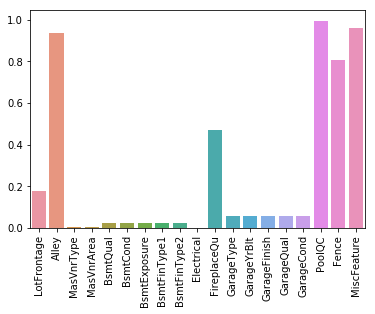

In [137]:
nulls = train.isnull().sum() / (len(train.index.values))
nulls = nulls[nulls>0]
p = sns.barplot(x = nulls.index, y = nulls.values)
p.set_xticklabels(nulls.index, rotation=90)

In [138]:
#drop columns that hvae more than 70% missing data
SP = train.loc[:, 'SalePrice']
col_to_drop = nulls.index.values[nulls>0.7].tolist() +['SalePrice']
train = train.drop(columns = col_to_drop)
train = pd.concat([train, SP], axis = 1)

test = test[train.columns.values[:-1]]

In [147]:
#replace categorical rating to ordinal
import numpy as np
cat_to_ord = []
for col in train.columns.values:
    if 'Gd' in train[col].unique():
        cat_to_ord.append(col)
train = train.replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], np.arange(5))
test = test.replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], np.arange(5))

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


In [148]:
#separate interger and categorical values
num= []
cat = []
ordinal = []
for c in train.columns.values:
    if type(train[c].unique()[0])== str or type(train[c].unique()[1]) == str:
        cat.append(c)
    elif len(train[c].unique()) > 100:
        num.append(c)
    else:
        ordinal.append(c)

In [149]:
for c in cat:
    train[c] = train[c].astype('category').cat.codes
    test[c] = test[c].astype('category').cat.codes

In [150]:
#fill in nas with knn
from sklearn.neighbors import KNeighborsClassifier
def fill_na(df):
    df = df.reset_index()
    col = df.columns.values.tolist()
    nulls = df.isnull().sum()
    nulls=nulls[nulls>0]
    nulls = nulls.sort_values(ascending = False)
    clf =KNeighborsClassifier(10)
    no_na_col = list(set(df.columns.values) - set(nulls.index.values))
    no_na_df = df[no_na_col]
    for c in nulls.index.values:
        #value_present = df[-df[c].isnull()]
        value_present = no_na_df[-df[c].isnull()]
        #value_present = value_present.dropna()
        #value_not_present = df[df[c].isnull()].loc[:, df.columns != c]
        value_not_present = no_na_df[df[c].isnull()]
        #value_not_present = value_not_present.fillna(0)
        #model = clf.fit(value_present.loc[:, value_present.columns != c], value_present[c])
        model = clf.fit(value_present, df[-df[c].isnull()][c])
        impute_value = model.predict(value_not_present)
        df.iloc[value_not_present.index.values,col.index(c)] = impute_value
    return(df)

new_train = fill_na(train.iloc[:,:-1])
test = fill_na(test)

In [151]:
new_train['SalePrice'] = np.array(train['SalePrice'])

In [152]:
train = new_train
train.isnull().sum().sum()

0

In [153]:
num_log_train = np.log(train[num]+1)
log_train = pd.concat((train[cat], train[ordinal], num_log_train), axis = 1)
log_train.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,TotalBsmtSF,FirstFlrSF,SecondFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,total_sf,SalePrice
0,3,1,3,3,0,4,0,5,2,2,...,6.753438,6.753438,6.751101,7.444833,6.308098,0.000000,4.127134,0.000000,8.137688,12.247699
1,3,1,3,3,0,2,0,24,1,2,...,7.141245,7.141245,0.000000,7.141245,6.133398,5.700444,0.000000,0.000000,7.833996,12.109016
2,3,1,0,3,0,4,0,5,2,2,...,6.825460,6.825460,6.765039,7.488294,6.411818,0.000000,3.761200,0.000000,8.181161,12.317171
3,3,1,0,3,0,0,0,6,2,2,...,6.629363,6.869014,6.629363,7.448916,6.466145,0.000000,3.583519,5.609472,8.141772,11.849405
4,3,1,0,3,0,2,0,15,2,2,...,7.044033,7.044033,6.960348,7.695758,6.729824,5.262690,4.442651,0.000000,8.388678,12.429220


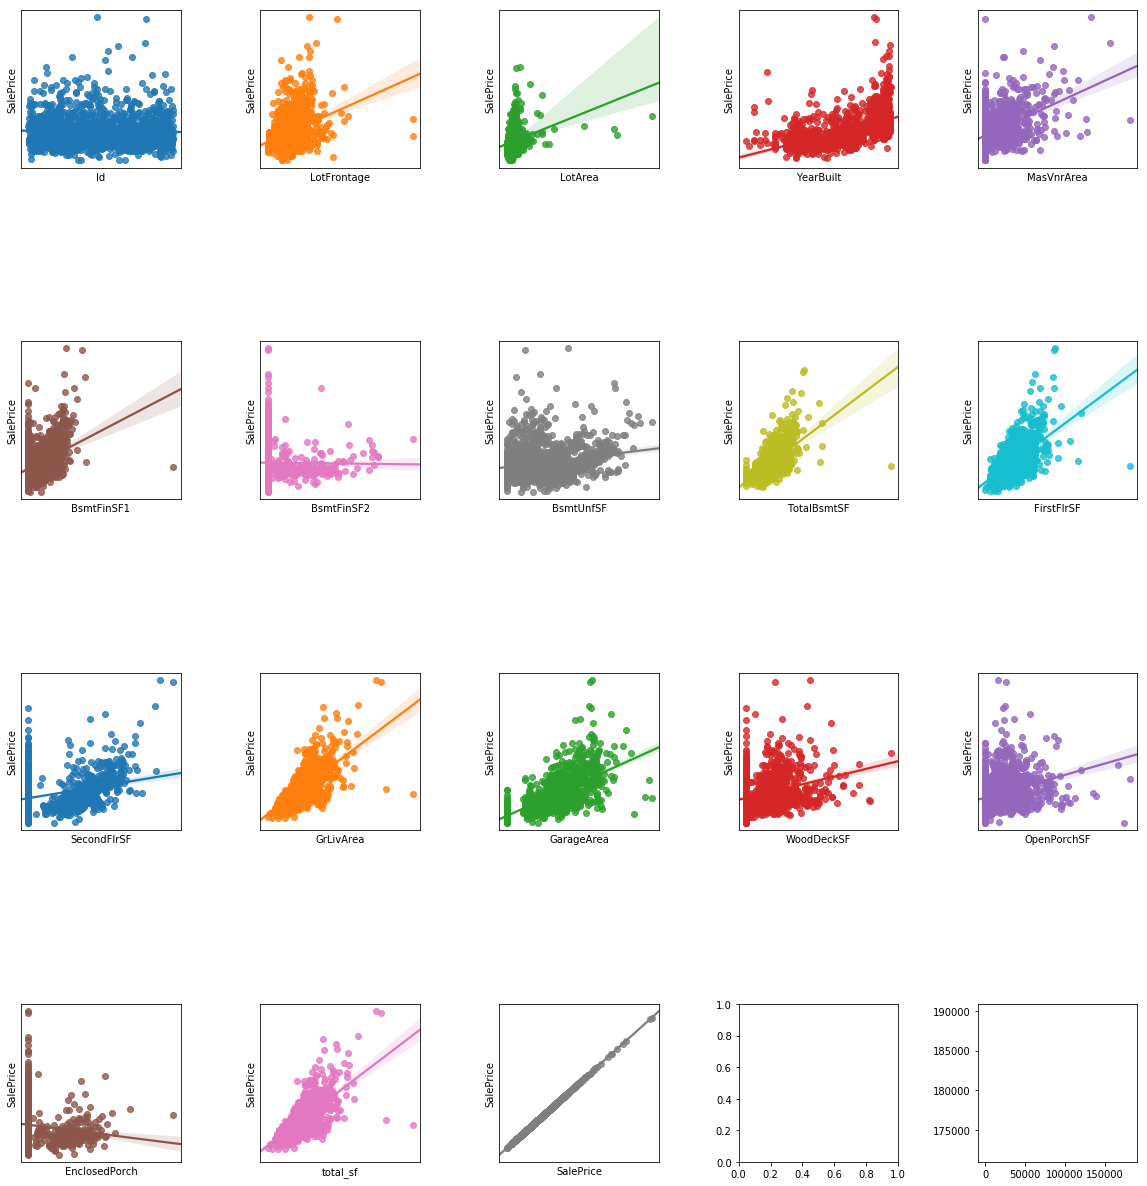

In [154]:
fig, ax = plt.subplots(figsize=(20,20), ncols= 5, nrows= int(math.ceil(len(num) / 5) ) +1)

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .5     # the amount of width reserved for blank space between subplots
hspace =  1.1    # the amount of height reserved for white space between subplots

plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)
num_train = train[num]
c = 0
for i in range(int(math.ceil(len(num) / 5)) + 1):
    for j in range(5):
        if c < len(num):
            sns.regplot(num_train.iloc[:, c], train.loc[:,'SalePrice'], ax=ax[i][j])
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            c= c  + 1



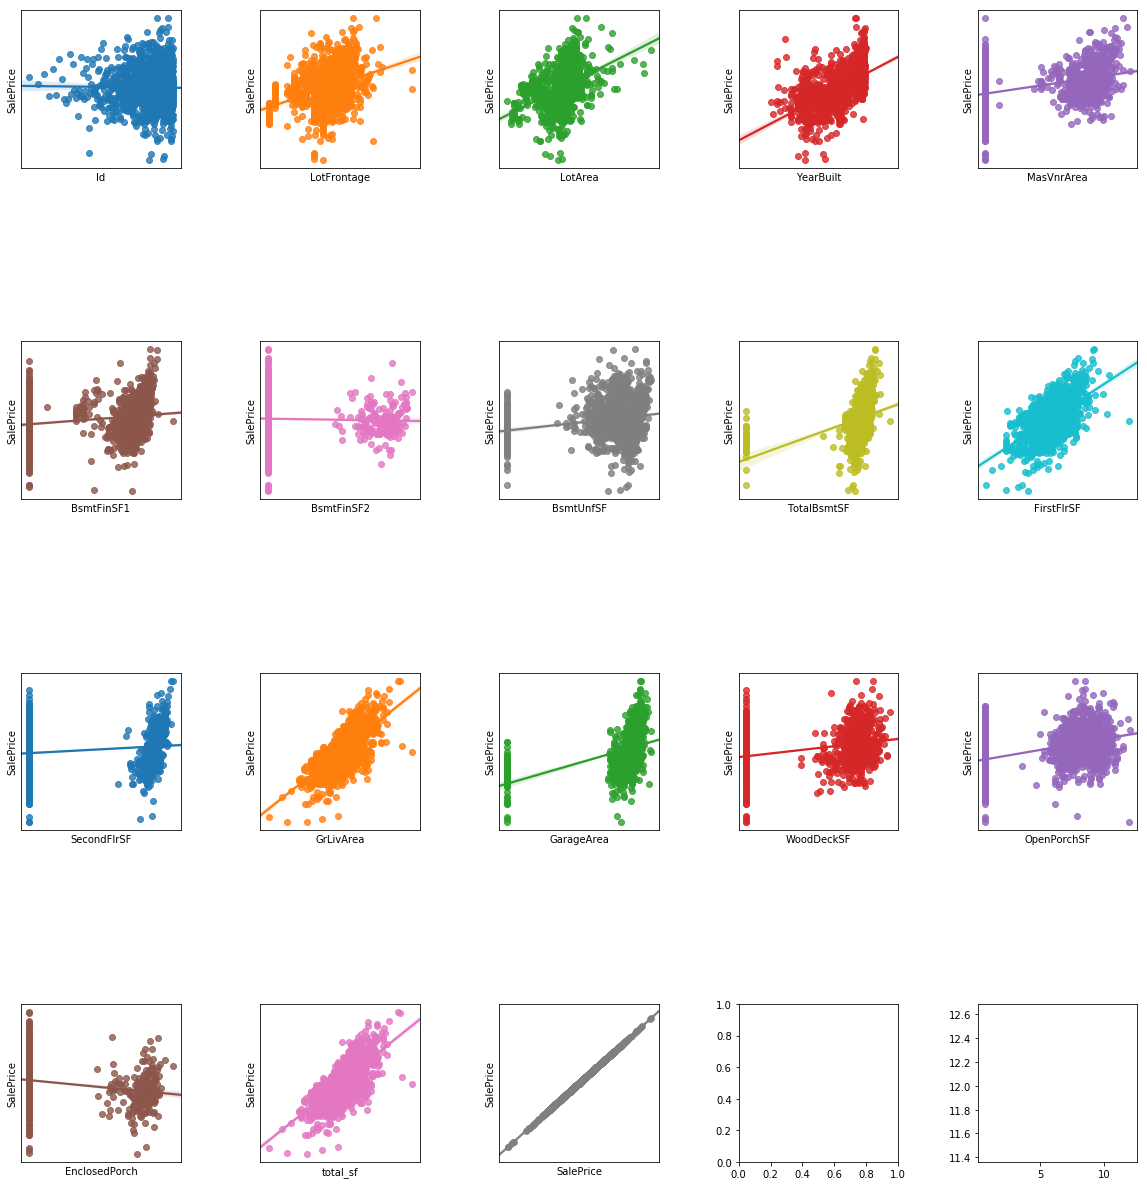

In [155]:
fig, ax = plt.subplots(figsize=(20,20), ncols= 5, nrows= int(math.ceil(len(num) / 5) ) +1)

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .5     # the amount of width reserved for blank space between subplots
hspace =  1.1    # the amount of height reserved for white space between subplots

plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)
num_train = log_train[num]
c = 0
for i in range(int(math.ceil(len(num) / 5)) + 1):
    for j in range(5):
        if c < len(num):
            sns.regplot(num_train.iloc[:, c], log_train.loc[:,'SalePrice'], ax=ax[i][j])
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            c= c  + 1

In [156]:
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
def find_outliers(col_list, target_variable, df, model = OneClassSVM()):
    outlier_index = []
    outlier_detector = model
    for c in col_list:
        outlier_detector.fit(df.loc[:,[c, target_variable]])
        p = outlier_detector.predict(df.loc[:,[c, target_variable]])
        i , = np.where(p == -1)
        outlier_index = outlier_index + i.tolist()
    return(outlier_index)
    



In [157]:
outlier = find_outliers(train.columns.values, 'SalePrice', train, model = EllipticEnvelope(contamination=.05))
outlier_log = find_outliers(log_train.columns.values, 'SalePrice', train, model = EllipticEnvelope(contamination=.05))

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.661474509831134 > 17.562397357009058)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.653348404065923 > 17.757562506275370)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.358316900649989 > 18.837757992673254)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.368110754336517 > 18.885234293661853)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.416831430314545 > 19.125

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.341825466245737 > 18.665444854704724)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.302633612502120 > 18.574211597756218)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.463318070171734 > 18.779644570000062)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.341825466245737 > 18.647077764190541)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.424499374141639 > 18.720

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.303557040144611 > 18.613801061030333)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.301515677211434 > 18.193063768187240)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.301515677211434 > 18.441861618576940)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.303557040144611 > 16.843460013518584)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.134913354702867 > 15.712

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.036189750974565 > 18.566504887929224)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.005619771809236 > 18.515307743663996)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.058583522022509 > 18.734019207160351)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.964773707688501 > 18.450574354582123)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.029315997535761 > 18.377

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.749141069422372 > 17.574142135138764)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.744296171402972 > 17.898360879679021)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.744296171402972 > 15.092859423426157)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.751813947829056 > 15.094183282575365)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (17.949284901247715 > 17.943

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.553743717052647 > 15.951013977079008)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.615317243462119 > 16.250450450387877)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.692287492993575 > 16.303497327893190)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.583171476482281 > 16.216437761526265)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.403900599447645 > 17.044

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.914690398447956 > 16.774398555682794)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.351870260820483 > 16.436415867368105)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.396729314363185 > 16.344506743679190)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.349264136507124 > 16.543506957543208)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.399904171045524 > 16.416

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.010945680151160 > 19.027345105615744)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.010945680151160 > 19.023561923550215)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.010945680151160 > 18.974316495707960)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.989123319274690 > 18.896487949239926)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.040817398243924 > 19.052

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.941679549791729 > 18.322957909927752)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.944495542775623 > 18.314624881879244)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.948059609520776 > 18.326780070274797)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.964177605946546 > 18.336621609531441)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.949979130156784 > 18.283

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.966718874780973 > 18.479803177352970)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.826978381035453 > 18.367312370970787)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.796660291159327 > 18.327981706632510)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.807663189380982 > 18.351727640327177)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.966718874780973 > 18.437

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.902158139803568 > 18.368170808420444)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.830054550957932 > 18.108018153684636)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.811820703780430 > 17.777615277617194)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.857754534656603 > 17.843026647160386)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.874049001972530 > 17.792

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.373592925656698 > 17.542573988452396)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.373592925656698 > 17.588737063893873)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.242986579430802 > 17.242903357496733)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.226169731568831 > 16.995088979909280)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.357972892862247 > 17.717

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (15.625018350974894 > 15.085224406045320)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (15.603089118468160 > 15.051173479461177)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (15.603089118468160 > 15.062611054631041)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (15.920878469552740 > 14.962034884219722)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.145795199545546 > 15.941

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.697440328967154 > 16.541654437117167)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.697440328967154 > 16.550997171376800)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.708390664068638 > 16.560360095407457)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.730340287778489 > 16.592447406037358)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.633248054148488 > 16.615

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.263287728569633 > 18.539702080238925)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.265752359225921 > 18.543189384973068)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.260808067034404 > 18.535583403605656)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.268349407037682 > 18.574800371136529)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.294202423928979 > 18.599

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.518418541361136 > 19.748213805823781)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.433598393257128 > 19.636625273792156)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.663177466672298 > 19.867742147408023)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.629398371002569 > 19.841707092159204)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.433598393257128 > 19.611

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.404978436619835 > 19.612108594329868)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.323611657472402 > 19.542586925030523)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.310302610509908 > 19.514887698194983)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.317350578278095 > 19.524411778083056)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.313817714306829 > 19.533

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.178063617946954 > 18.803786256068200)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.576364440325918 > 18.665220814784355)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.556440897436282 > 18.766497056479146)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.486115063377639 > 18.451373470171141)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.494283297745589 > 18.468

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.400399824623442 > 16.263896669061328)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.903281622478939 > 16.310420806629413)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.646033104177114 > 16.499298058820155)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.653743684827617 > 16.538941751752983)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.655719464994455 > 16.553

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.303596766308740 > 16.187587056945951)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.610754698751261 > 16.322658820152338)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.443487042346391 > 16.335413025296543)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.610754698751261 > 16.312809016508460)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.312809016508460 > 16.210

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.020834836684202 > 14.938690780062577)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.237610121864272 > 14.860564603110550)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.142327000127118 > 15.071257493026803)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.221383214294580 > 15.160359805846682)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.020834836684202 > 14.912

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.663576783951328 > 17.690881802069029)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.661474509831134 > 17.561052454256686)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.657932440741966 > 17.604600063220062)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (13.953641855238821 > 13.281929897768523)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (13.957463578135190 > 13.288

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.301515677211434 > 17.059176018875196)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.144317884497625 > 15.827254565475478)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.073626747801050 > 16.020444439457833)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.145086350182062 > 15.805811932173780)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.147858164390012 > 15.810

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.001414681465839 > 18.498652435144521)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.001414681465839 > 18.482472805262248)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.973139119961459 > 18.467792313874149)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.060264252444831 > 18.732254518964666)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.158612162865705 > 19.148

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.747472814154605 > 14.689031203240937)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.995699252308508 > 16.968526153241548)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.848275511513719 > 16.572654633854754)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.848275511513719 > 16.589347472576780)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.720750659697600 > 16.622

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.799608024602783 > 17.078553116649182)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.254909828982846 > 17.229815961195236)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.182452050268981 > 16.994603742089211)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.182452050268981 > 17.013173854773541)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.300319326146489 > 17.274

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.540223278630840 > 16.153851169663064)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.628466301112780 > 16.484717854913157)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.648008998196630 > 17.035806848827335)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.637912964675898 > 16.981804470967308)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.637912964675898 > 16.499

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.185983354658639 > 20.421757946702328)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.186261083437746 > 20.430100580231713)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.186261083437746 > 20.428196148293036)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.165592284818739 > 20.440108044048966)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.162906933470779 > 20.450

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.930473193454617 > 18.692399935584433)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.979959302488336 > 18.956266666452361)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.645047836127226 > 18.224066917490283)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.560252198335863 > 18.111189428200067)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.589817920368194 > 18.144

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.923734428709345 > 17.407570384218573)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.881310347878085 > 17.344319127698185)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.923734428709349 > 16.999240808845126)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.946948512063273 > 17.038335815599446)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.935701914256654 > 17.146

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (15.451219600808251 > 15.034080642188265)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (15.437801355996186 > 14.994501365157126)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (15.451219600808251 > 15.054320698668173)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (15.413853423539646 > 14.929477328370135)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (17.259097422754607 > 15.105

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.812400892857859 > 16.793362457533142)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.787342921777274 > 16.767870853498771)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.740778640424473 > 16.705699317980987)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.763821264117215 > 16.744214861808878)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.870209535635087 > 16.832

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.994907978478107 > 15.793228995665199)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.990421149943984 > 16.094631594094650)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.221270778562136 > 19.572410356392837)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.263580883149078 > 19.608868069788429)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.184664835080905 > 19.541

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.486237876352043 > 19.397123481197848)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.429947039485953 > 19.839050897663526)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.066305175897881 > 19.310367190050723)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.083975817292604 > 19.339842364530060)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.158195034880464 > 19.390

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.398497791156245 > 18.218929525933341)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.388068183175935 > 18.211920987413475)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.308799452695919 > 18.259474554206307)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.408585194273364 > 18.308799452695919)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.328792843982427 > 18.268

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.946115698430344 > 18.053423754805042)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.900005612313109 > 17.992862365224642)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.009496649983127 > 17.314296826882700)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (21.159888083083224 > 18.047856296291151)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.389928786315313 > 15.966

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.042724694473698 > 15.309264787476739)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.151643723776768 > 15.382269129281422)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.016407037649287 > 15.135282294396543)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.034317276474965 > 15.272936011492387)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.968423375420983 > 15.180

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.137472455697690 > 19.019661179890903)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.171637482677209 > 19.030575546391233)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.156648775982966 > 19.029687419327821)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.076814263423522 > 18.997776400511665)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (20.156648775982966 > 19.021

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (17.909565666494927 > 17.635032478008455)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (17.931551739583298 > 17.638363670890811)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (17.939713030127635 > 17.651999855327752)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (17.873015656147057 > 17.865241583385664)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (17.831186766614028 > 17.802

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.280693513006753 > 18.610156418510769)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.292580936835051 > 18.609262511694421)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.285686949793067 > 18.609859779911432)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.279567349480267 > 18.616857968008887)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (19.292580936835051 > 18.610

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.757046053970409 > 18.190916751033061)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.765885654266278 > 18.206216512137811)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.769067260431875 > 18.214259239526076)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.776455015451575 > 18.224002431755501)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (18.776455015451575 > 18.222

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.499320170280203 > 16.374239717934369)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.397319314085607 > 16.132166328254126)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.495099977632691 > 16.232063885503216)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.439498537652732 > 16.188127116240771)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.467697450913377 > 16.217

/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.256797250210060 > 16.071442152491574)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.103595917178247 > 15.894950569651948)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.167017982232746 > 15.956262390607128)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.813007608829903 > 16.705482002406320)
  % (det, previous_det), RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (16.657364038408392 > 16.550

In [158]:
outlier_index = [int(i) for i in set(outlier).intersection(set(outlier_log))]
no_outliers_train_log = log_train.drop(log_train.index[outlier_index])
no_outliers_train = train.drop(train.index[outlier_index])

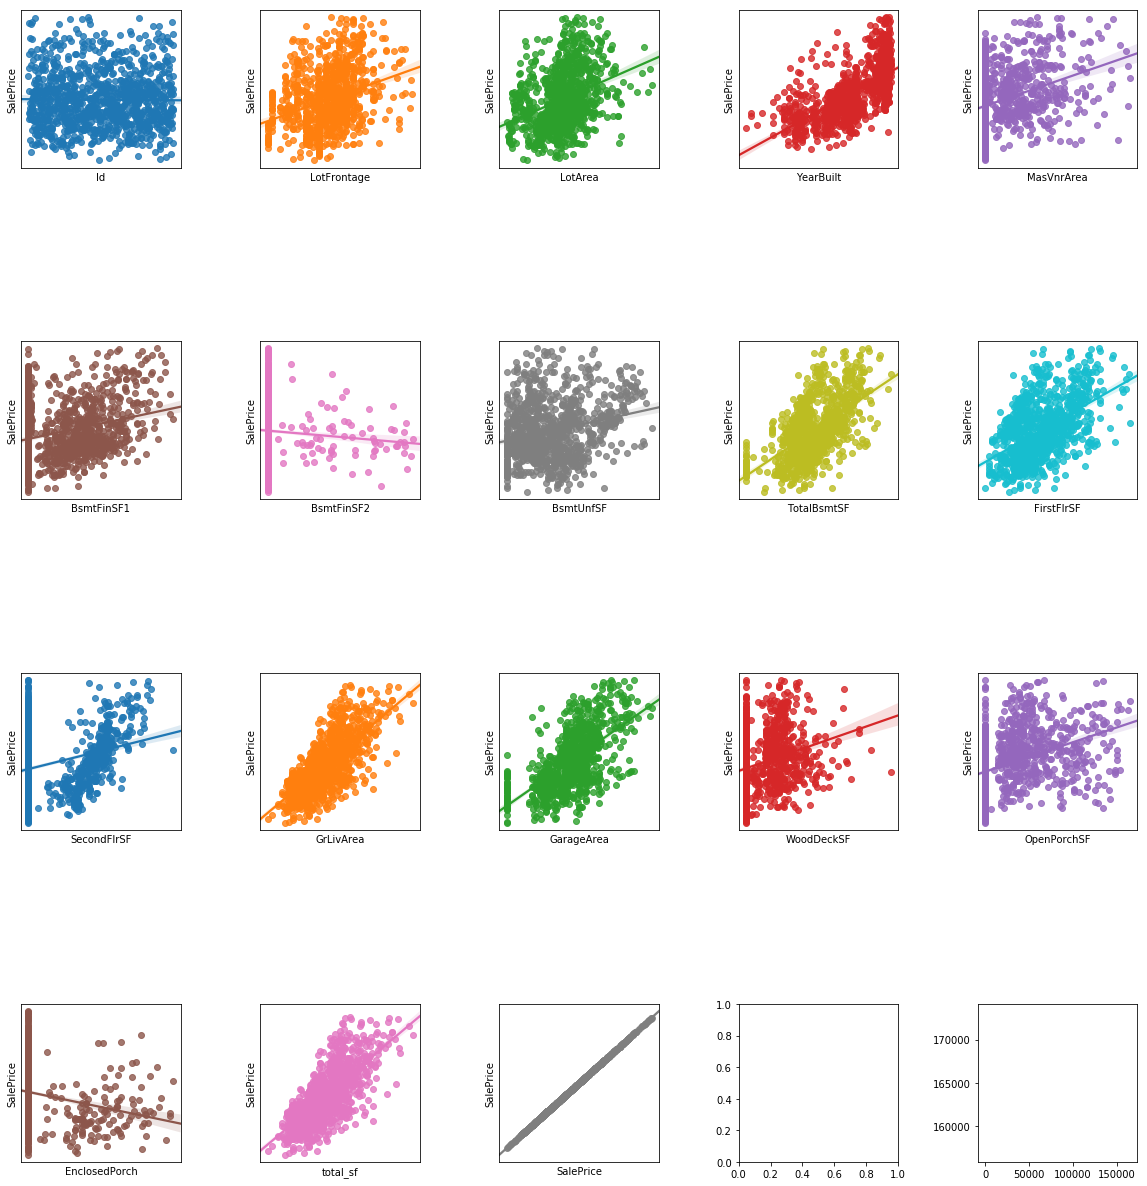

In [159]:
fig, ax = plt.subplots(figsize=(20,20), ncols= 5, nrows= int(math.ceil(len(num) / 5) ) + 1)

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .5     # the amount of width reserved for blank space between subplots
hspace =  1.1    # the amount of height reserved for white space between subplots

plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

outliers_train_num = no_outliers_train[num]
c = 0
for i in range(int(math.ceil(len(num) / 5)) + 1):
    for j in range(5):
        if c < len(num):
            sns.regplot(outliers_train_num.iloc[:, c], no_outliers_train.loc[:,'SalePrice'], ax=ax[i][j])
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            c= c  + 1

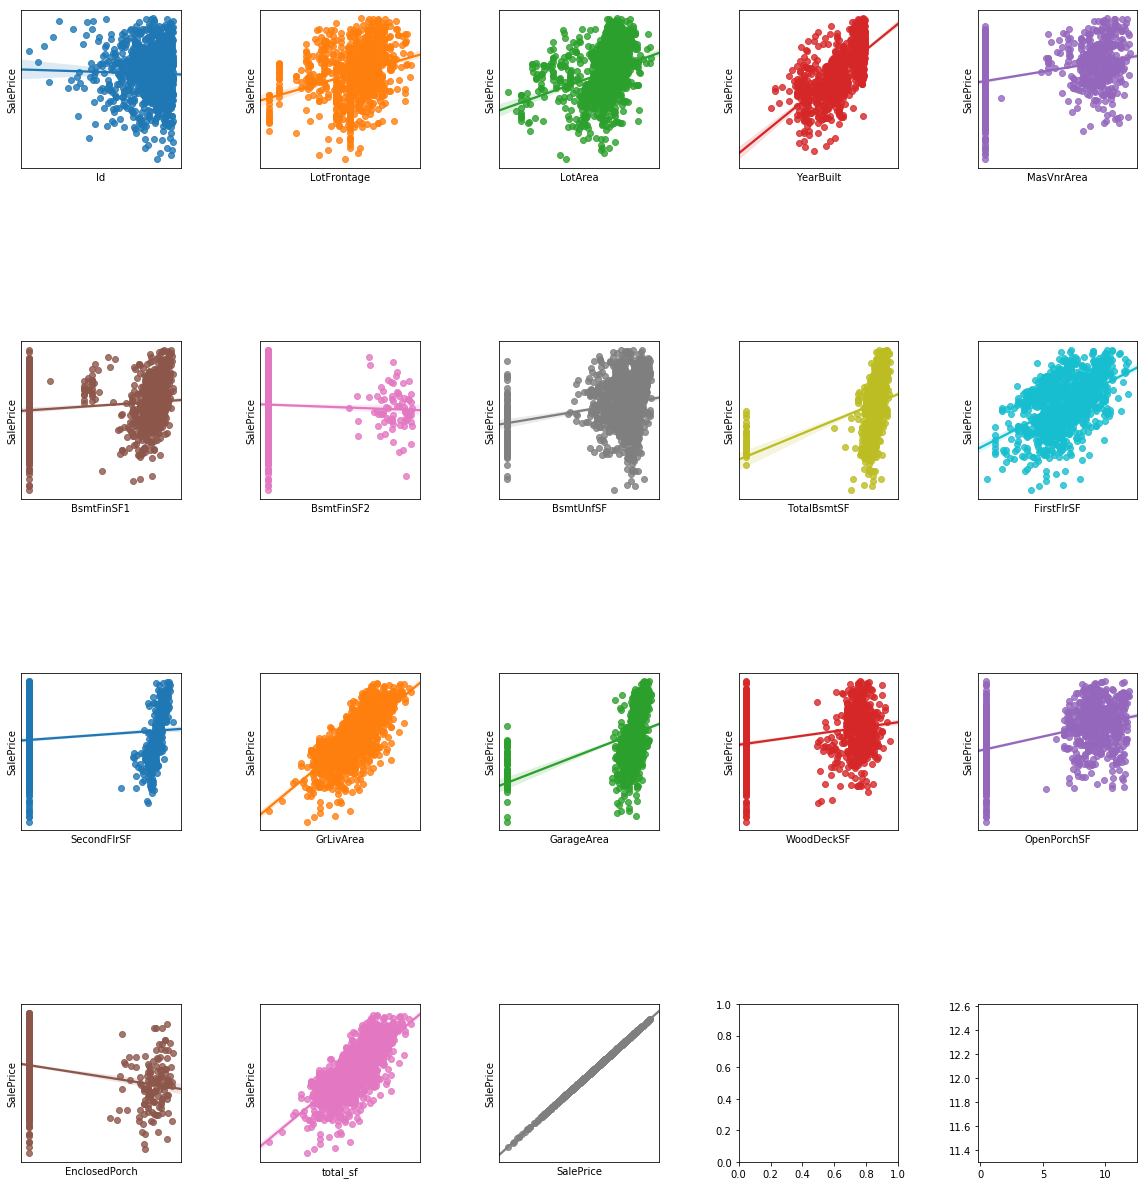

In [160]:
fig, ax = plt.subplots(figsize=(20,20), ncols= 5, nrows= int(math.ceil(len(num) / 5) ) + 1)

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .5     # the amount of width reserved for blank space between subplots
hspace =  1.1    # the amount of height reserved for white space between subplots

plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

outliers_train_num = no_outliers_train_log[num]
c = 0
for i in range(int(math.ceil(len(num) / 5)) + 1):
    for j in range(5):
        if c < len(num):
            sns.regplot(outliers_train_num.iloc[:, c], no_outliers_train_log.loc[:,'SalePrice'], ax=ax[i][j])
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            c= c  + 1

In [161]:
def sig_num_var(df, target_var, num_var_list):
    sig_num = []
    y = df[target_var]
    df[num_var_list] = df[num_var_list].astype(float)
    for col in num_var_list:
        x = df[col]
        corr = pearsonr(x,y)
        if corr[1] < 0.05:
            sig_num.append(col)
    return(sig_num)

sig_num = sig_num_var(no_outliers_train, 'SalePrice', num)
sig_num_log = sig_num_var(no_outliers_train_log, 'SalePrice', num)

In [162]:
#find collinearity
high_cor_features = "+".join(sig_num)
y, X = dmatrices('SalePrice ~' + high_cor_features , no_outliers_train, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,1.101848e+04,Intercept
1,1.720927e+00,LotFrontage
2,1.806761e+00,LotArea
3,2.359579e+00,YearBuilt
4,1.194814e+00,MasVnrArea
5,inf,BsmtFinSF1
6,inf,BsmtFinSF2
7,inf,BsmtUnfSF
8,inf,TotalBsmtSF
9,inf,FirstFlrSF


In [164]:
features_to_remove = [f for f in list(vif[vif['VIF Factor'] >5]['features'])]
features_to_remove = [s for s in features_to_remove if s not in ['TotalBsmtSF', 'total_sf', 'Intercept']]
new_sig_num = list(set(sig_num) - set(features_to_remove))
#new_sig_num.remove('SalePrice')

In [165]:
high_cor_features = "+".join(new_sig_num)
y, X = dmatrices('SalePrice ~' + high_cor_features , no_outliers_train, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,8431.935883,Intercept
1,1.180313,MasVnrArea
2,1.244310,EnclosedPorch
3,1.706077,LotFrontage
4,1.197442,OpenPorchSF
5,1.764292,LotArea
6,1.812613,YearBuilt
7,1.632929,GarageArea
8,1.370551,TotalBsmtSF
9,1.507288,total_sf


In [166]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import numpy as np
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(no_outliers_train[new_sig_num], no_outliers_train['SalePrice'], test_size=0.4, random_state=0)

lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)
model= model.predict(X_test)
mean_squared_error(y_test, model)

628599541.9732833

In [167]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import numpy as np
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(no_outliers_train_log[new_sig_num], no_outliers_train_log['SalePrice'], test_size=0.4, random_state=0)

lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)
model= model.predict(X_test)
mean_squared_error(y_test, model)

0.025248599822551527

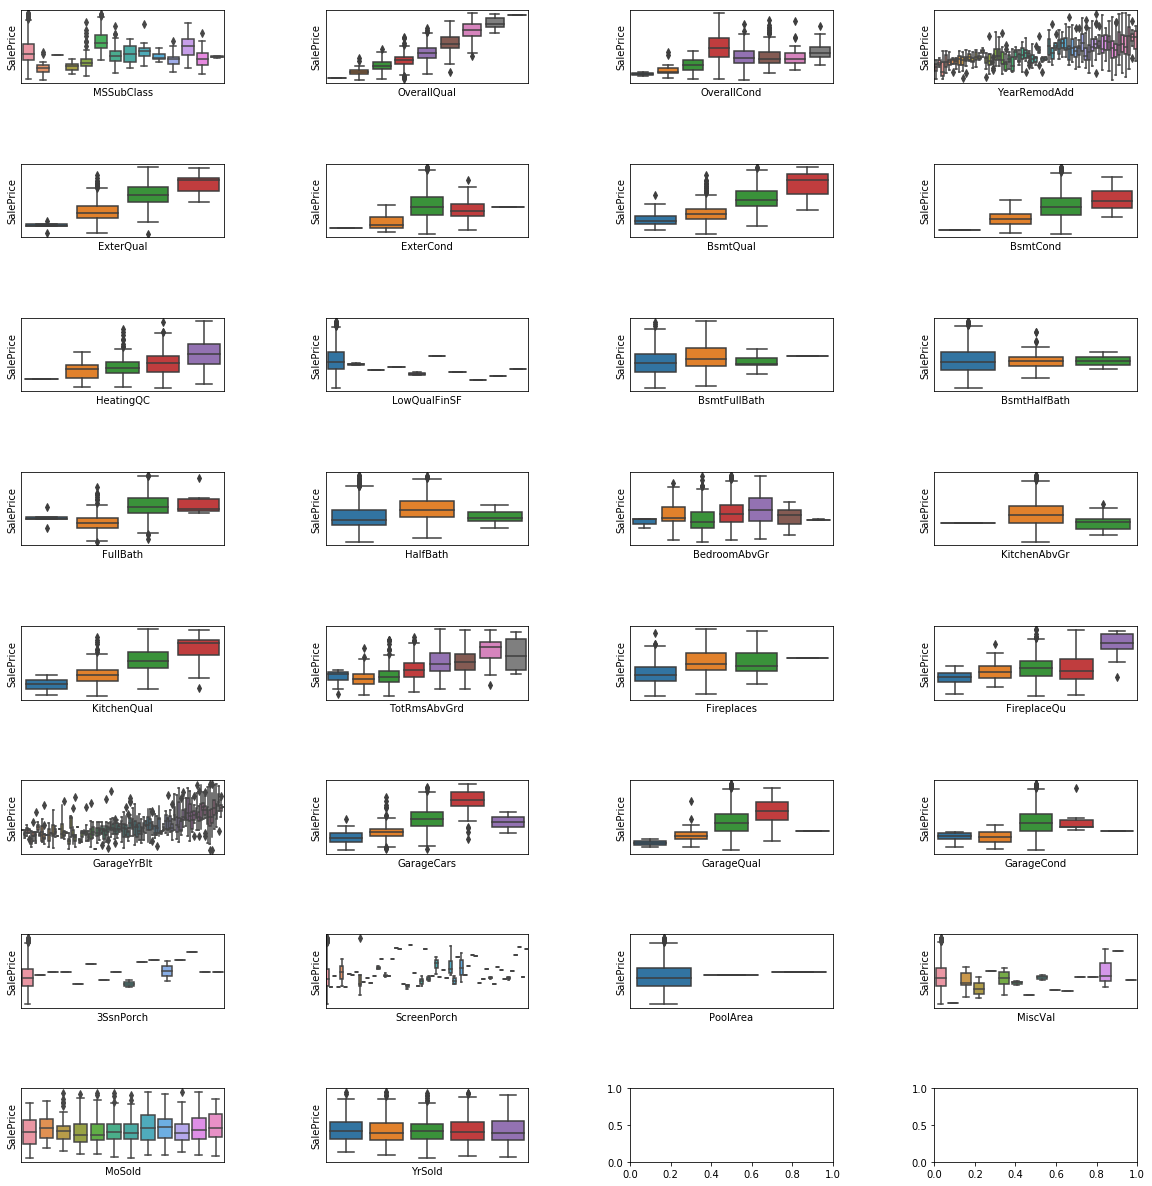

In [169]:
## Ordinal
fig, ax = plt.subplots(figsize=(20,20), ncols= 4, nrows= int(math.ceil(len(ordinal) / 4) +1))

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .5     # the amount of width reserved for blank space between subplots
hspace =  1.1    # the amount of height reserved for white space between subplots

plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

ordinal_train = no_outliers_train[ordinal]
c = 0
for i in range(int(math.ceil(len(ordinal) / 4) +1)):
    for j in range(4):
        if c < len(ordinal):
            sns.boxplot(ordinal_train.iloc[:, c], no_outliers_train.loc[:,'SalePrice'], ax=ax[i][j])
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            c= c  + 1

In [170]:
from scipy import stats

def sig_ordinal_var(df, ordinal_list):
    sig_ordinal = []
    for col in ordinal_list:
        ordinal_groups = {}
        for group in df[col].unique():
            ordinal_groups[group] = df[df[col] == group]['SalePrice'].values
        args = ordinal_groups.values()
        full_args = [l for l in args if len(l) > 5]
        if len(full_args) > 1 :
            statistic, pvalue = stats.kruskal(*full_args)
            if pvalue <0.05:
                sig_ordinal.append(col)
    return(sig_ordinal)

sig_ordinal = sig_ordinal_var(no_outliers_train, ordinal)
sig_ordinal_log = sig_ordinal_var(no_outliers_train_log, ordinal)

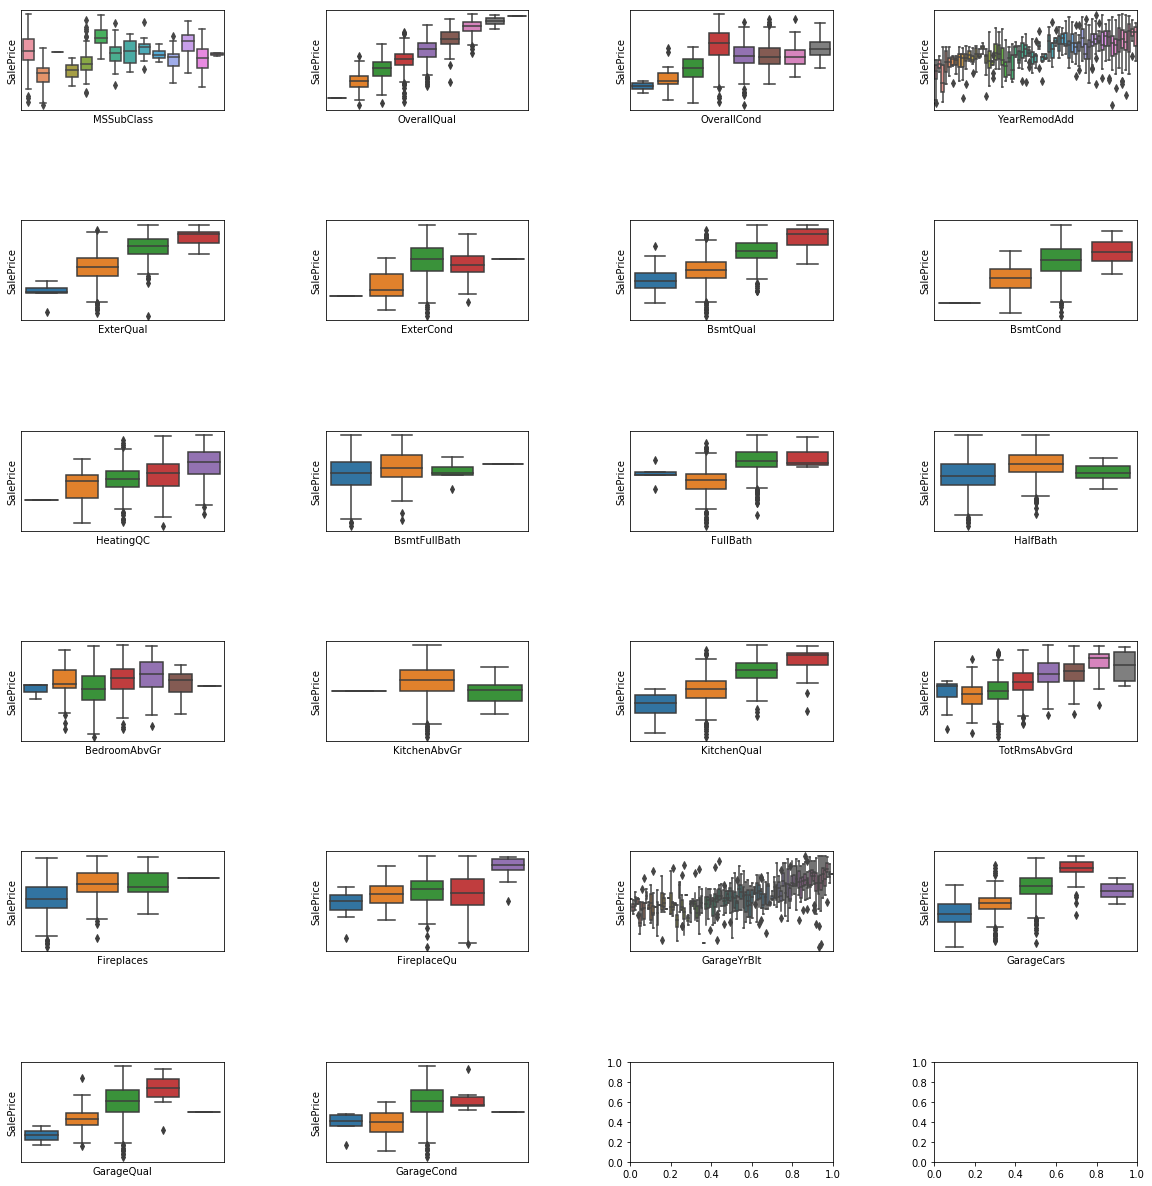

In [174]:
fig, ax = plt.subplots(figsize=(20,20), ncols= 4, nrows= int(math.ceil(len(sig_ordinal_log) / 4) + 1 ))

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9  # the top of the subplots of the figure
wspace =  .5     # the amount of width reserved for blank space between subplots
hspace =  1.1    # the amount of height reserved for white space between subplots

plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

ordinal_train = no_outliers_train_log[sig_ordinal_log]
c = 0
for i in range(int(math.ceil(len(sig_ordinal_log) / 4) + 1)):
    for j in range(4):
        if c < len(sig_ordinal_log):
            sns.boxplot(ordinal_train.iloc[:, c], no_outliers_train_log.loc[:,'SalePrice'], ax=ax[i][j])
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            c= c  + 1

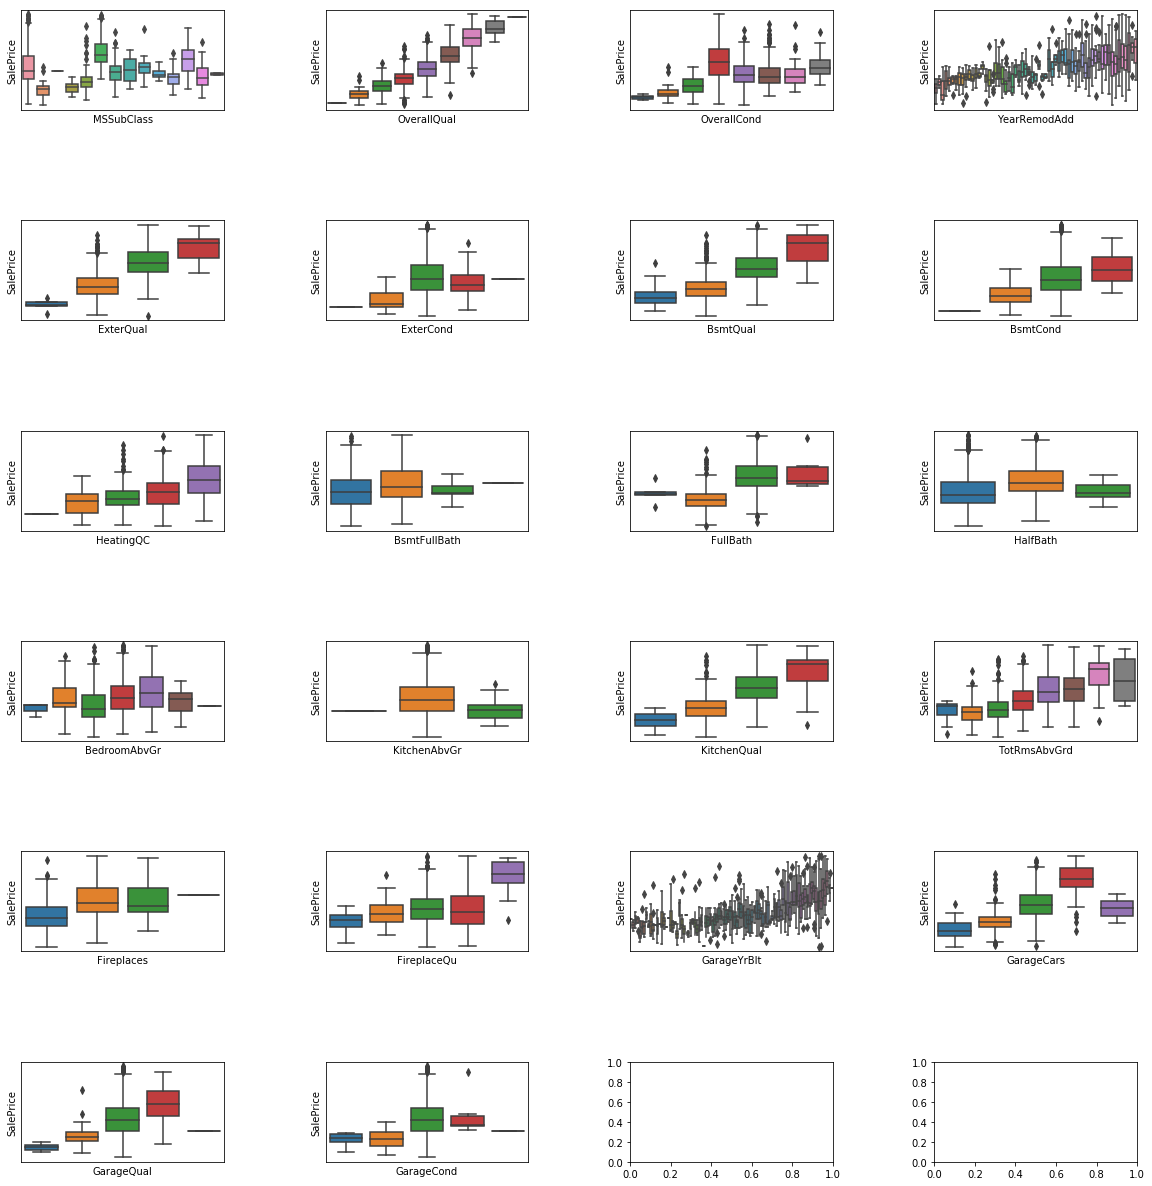

In [175]:
fig, ax = plt.subplots(figsize=(20,20), ncols= 4, nrows= int(math.ceil(len(sig_ordinal) / 4) + 1 ))

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9  # the top of the subplots of the figure
wspace =  .5     # the amount of width reserved for blank space between subplots
hspace =  1.1    # the amount of height reserved for white space between subplots

plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

ordinal_train = no_outliers_train[sig_ordinal]
c = 0
for i in range(int(math.ceil(len(sig_ordinal) / 4) + 1)):
    for j in range(4):
        if c < len(sig_ordinal):
            sns.boxplot(ordinal_train.iloc[:, c], no_outliers_train.loc[:,'SalePrice'], ax=ax[i][j])
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            c= c  + 1

In [180]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
pair = []
for col in sig_ordinal:
    sp = no_outliers_train['SalePrice']
    group = no_outliers_train.loc[:,col]
    tuk = pairwise_tukeyhsd(sp, group).summary()
    print(col)
    print(tuk)
    #tuk_neg= tuk[tuk['reject'] == False]
    #pair.append([col, tuk_neg])
    #print col
    #print pairwise_tukeyhsd(sp, group)

MSSubClass
    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
group1 group2   meandiff     lower        upper    reject
---------------------------------------------------------
  20     30   -70230.1209 -90439.9403  -50020.3014  True 
  20     40   -14675.8278 -159080.0746  129728.419 False 
  20     45   -60884.9187 -104940.9384  -16828.899  True 
  20     50   -39767.6383 -56161.0684  -23374.2081  True 
  20     60    43607.5619  31465.3493   55749.7745  True 
  20     70   -12664.3429 -38744.1428   13415.457  False 
  20     75   -10550.8278 -83010.9703   61909.3148 False 
  20     80    -3422.6363 -25612.2888   18767.0163 False 
  20     85   -20636.9389 -55356.9572   14083.0795 False 
  20     90   -36060.4856 -60498.3684  -11622.6029  True 
  20    120    22750.9084  4347.2253    41154.5914  True 
  20    160   -30985.6135  -51509.902  -10461.3249  True 
  20    180   -22342.4944 -105913.0664  61228.0776 False 
  30     40    55554.2931 -89915.5948   201024.181 False 
  3

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
group1 group2   meandiff      lower        upper    reject
----------------------------------------------------------
1906.0 1910.0   -19000.0   -233738.2953 195738.2953 False 
1906.0 1915.0   -3800.0    -218538.2953 210938.2953 False 
1906.0 1916.0   -9200.0    -201267.7703 182867.7703 False 
1906.0 1920.0   -45020.0   -228910.8898 138870.8898 False 
1906.0 1921.0   -15600.0   -207667.7703 176467.7703 False 
1906.0 1922.0   -11720.0   -203787.7703 180347.7703 False 
1906.0 1923.0   10000.0    -204738.2953 224738.2953 False 
1906.0 1924.0 -18833.3333  -221290.5397  183623.873 False 
1906.0 1925.0 -11435.7143  -198874.6653 176003.2367 False 
1906.0 1926.0 -17527.2727  -200656.7063 165602.1608 False 
1906.0 1927.0   -20000.0   -267958.4252 227958.4252 False 
1906.0 1928.0   -22250.0   -236988.2953 192488.2953 False 
1906.0 1929.0   -15000.0   -262958.4252 232958.4252 False 
1906.0 1930.0  -4142.2857  -191581.2367 183296.6653 Fals

In [185]:
#grouping ordinal factors
no_outliers_train['BsmtFullBath'] = no_outliers_train['BsmtFullBath'].replace(2, 1)
no_outliers_train['OverallCond'] = no_outliers_train['OverallCond'].replace([2,3,4,6,7,8], [1,1,1,9,9,9])
no_outliers_train['OverallQual'] = no_outliers_train['OverallQual'].replace([1,2,3], [4,4,4])
no_outliers_train['TotRmsAbvGrd'] = no_outliers_train['TotRmsAbvGrd'].replace([2,3,4,7,9,11], [5,5,5,8,10,12])
no_outliers_train['HalfBath'] = no_outliers_train['HalfBath'].replace(2, 1)
no_outliers_train['FullBath'] = no_outliers_train['FullBath'].replace(0, 1)
no_outliers_train['BedroomAbvGr'] = no_outliers_train['BedroomAbvGr'].replace([0,1,5,6], [2,2,4,4])
no_outliers_train['Fireplaces'] = no_outliers_train['Fireplaces'].replace([2,3], [1,1])
no_outliers_train['GarageCars'] = no_outliers_train['GarageCars'].replace(4,3)
no_outliers_train['ExterCond'] = no_outliers_train['ExterCond'].replace([0,3,4], [1,2,2])
no_outliers_train['BsmtQual'] = no_outliers_train['BsmtQual'].replace(1,2)
no_outliers_train['BsmtCond'] = no_outliers_train['BsmtCond'].replace(0,1)
no_outliers_train['BsmtCond'] = no_outliers_train['BsmtCond'].replace(0,1)
no_outliers_train['HeatingQC'] = no_outliers_train['HeatingQC'].replace([0,1], [2,2])
no_outliers_train['FireplaceQu'] = no_outliers_train['FireplaceQu'].replace([0,2], [1,3])
no_outliers_train['GarageQual'] = no_outliers_train['GarageQual'].replace([0,3,4], [1,2,2])
no_outliers_train['GarageCond'] = no_outliers_train['GarageCond'].replace([0,3,4], [1,2,2])
no_outliers_train['BsmtFullBath'] = no_outliers_train['BsmtFullBath'].replace(3, 1)


no_outliers_train_log[sig_ordinal] = no_outliers_train[sig_ordinal]

test['BsmtFullBath'] = test['BsmtFullBath'].replace(2, 1)
test['OverallCond'] = test['OverallCond'].replace([2,3,4,6,7,8], [1,1,1,9,9,9])
test['OverallQual'] = test['OverallQual'].replace([1,2,3], [4,4,4])
test['TotRmsAbvGrd'] = test['TotRmsAbvGrd'].replace([2,3,4,7,9,11], [5,5,5,8,10,12])
test['HalfBath'] = test['HalfBath'].replace(2, 1)
test['FullBath'] = test['FullBath'].replace(0, 1)
test['BedroomAbvGr'] = test['BedroomAbvGr'].replace([0,1,5,6], [2,2,4,4])
test['Fireplaces'] = test['Fireplaces'].replace([2,3], [1,1])
test['GarageCars'] = test['GarageCars'].replace(4,3)
test['ExterCond'] = test['ExterCond'].replace([0,3,4], [1,2,2])
test['BsmtQual'] = test['BsmtQual'].replace(1,2)
test['BsmtCond'] = test['BsmtCond'].replace(0,1)
test['HeatingQC'] = test['HeatingQC'].replace([0,1], [2,2])
test['FireplaceQu'] = test['FireplaceQu'].replace([0,2], [1,3])
test['GarageQual'] = test['GarageQual'].replace([0,3,4], [1,2,2])
test['GarageCond'] = test['GarageCond'].replace([0,3,4], [1,2,2])
test['BsmtFullBath'] = test['BsmtFullBath'].replace(3, 1)



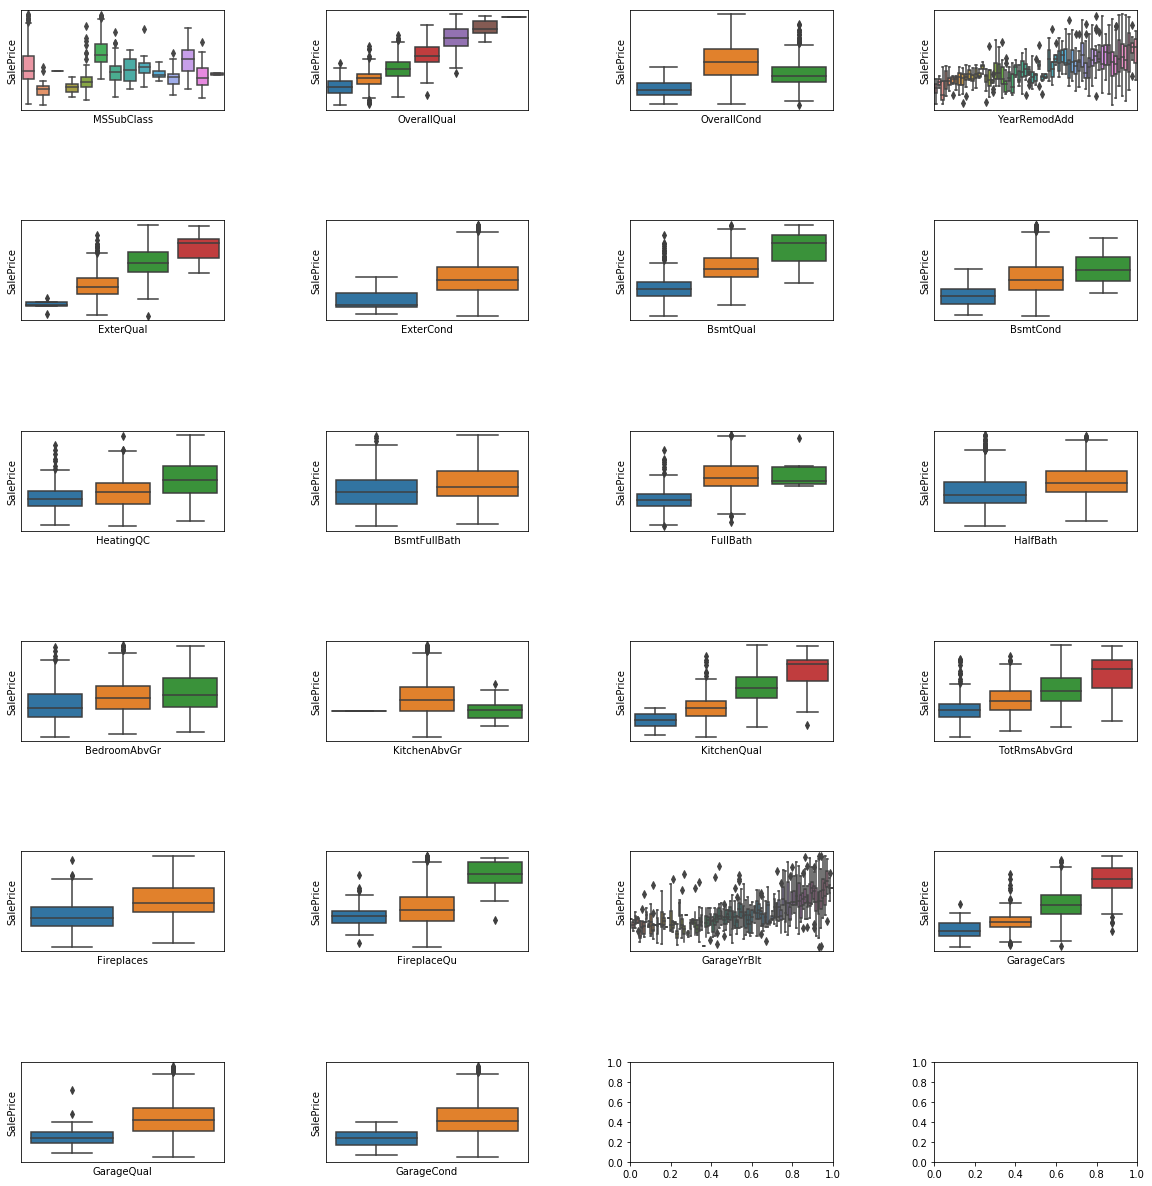

In [186]:
fig, ax = plt.subplots(figsize=(20,20), ncols= 4, nrows= int(math.ceil(len(sig_ordinal) / 4) +1 ))

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9  # the top of the subplots of the figure
wspace =  .5     # the amount of width reserved for blank space between subplots
hspace =  1.1    # the amount of height reserved for white space between subplots

plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

ordinal_train = no_outliers_train[sig_ordinal]
c = 0
for i in range(int(math.ceil(len(sig_ordinal) / 4) + 1)):
    for j in range(4):
        if c < len(sig_ordinal):
            sns.boxplot(ordinal_train.iloc[:, c], no_outliers_train.loc[:,'SalePrice'], ax=ax[i][j])
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            c= c  + 1

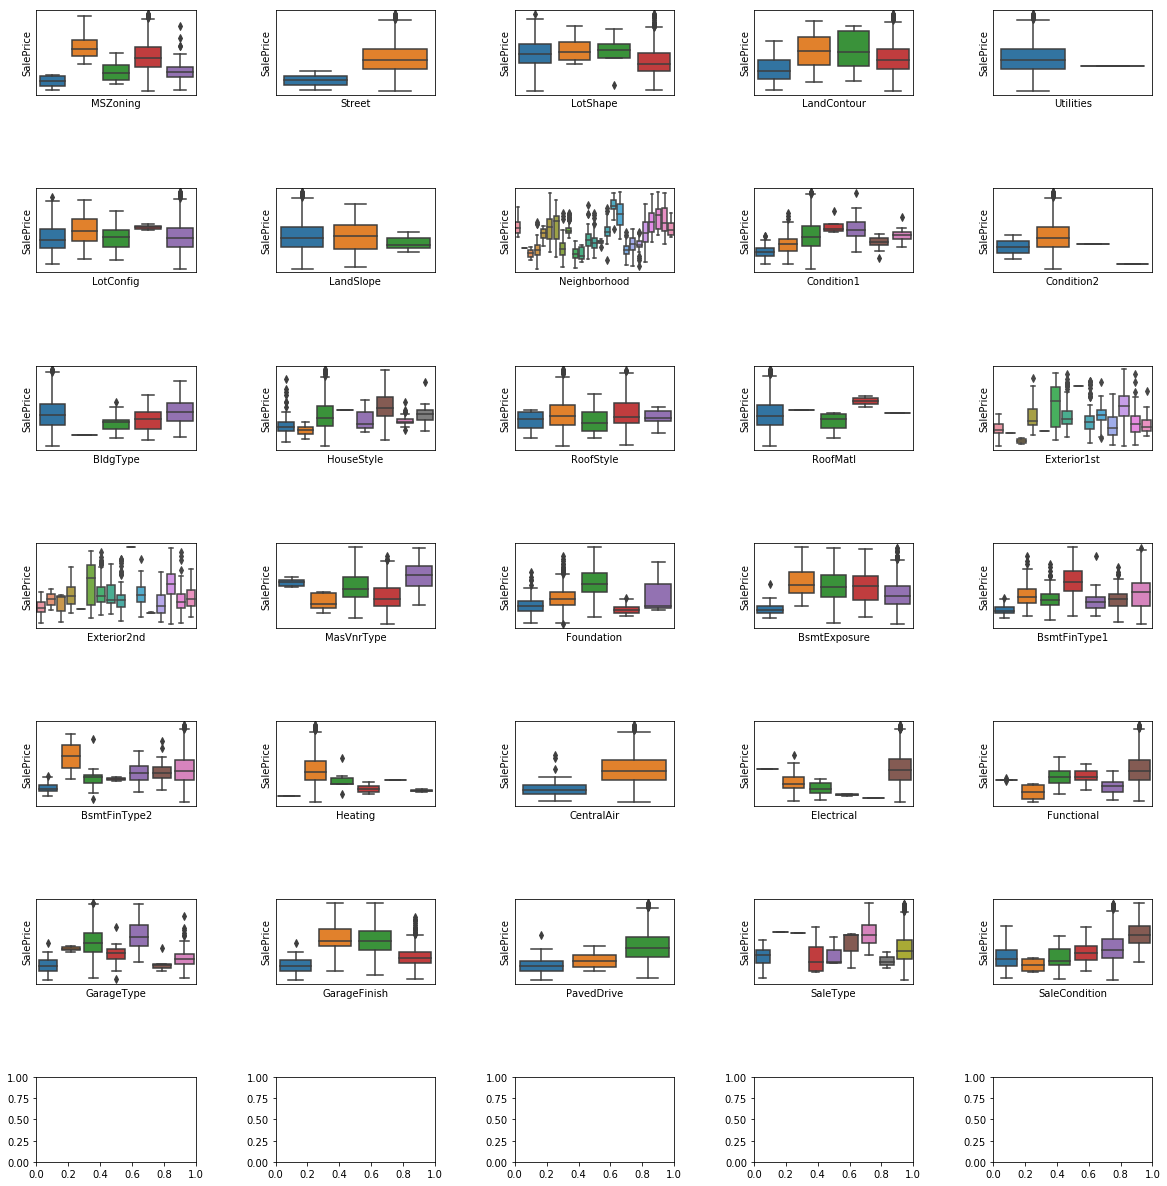

In [187]:
fig, ax = plt.subplots(figsize=(20,20), ncols= 5, nrows= int(math.ceil(len(cat) / 5) +1))

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .5     # the amount of width reserved for blank space between subplots
hspace =  1.1    # the amount of height reserved for white space between subplots

plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

cat_train = no_outliers_train[cat]
c = 0
for i in range(int(math.ceil(len(cat) / 5) +1)):
    for j in range(5):
        if c < len(cat):
            sns.boxplot(cat_train.iloc[:, c], no_outliers_train.loc[:,'SalePrice'], ax=ax[i][j])
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            c= c  + 1

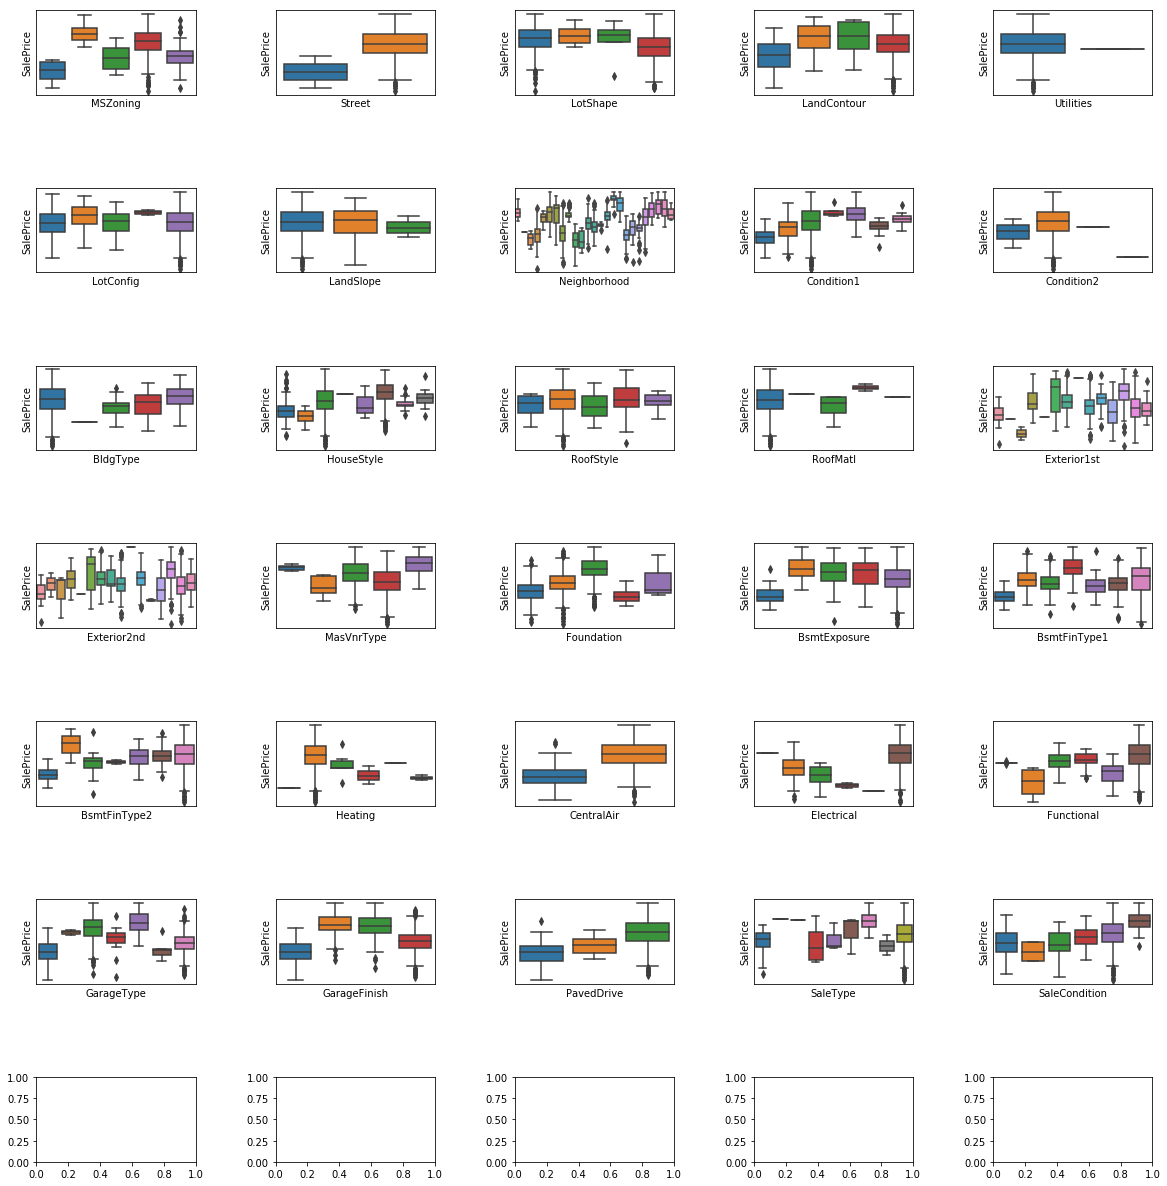

In [188]:
fig, ax = plt.subplots(figsize=(20,20), ncols= 5, nrows= int(math.ceil(len(cat) / 5) +1))

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .5     # the amount of width reserved for blank space between subplots
hspace =  1.1    # the amount of height reserved for white space between subplots

plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

cat_train = no_outliers_train_log[cat]
c = 0
for i in range(int(math.ceil(len(cat) / 5) +1)):
    for j in range(5):
        if c < len(cat):
            sns.boxplot(cat_train.iloc[:, c], no_outliers_train_log.loc[:,'SalePrice'], ax=ax[i][j])
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            c= c  + 1

In [190]:
def sig_cat_var(df, cat_list):
    sig_cat = []
    for col in cat_list:
        cat_groups = {}
        for group in df[col].unique():
            cat_groups[group] = df[df[col] == group]['SalePrice'].values
        args = cat_groups.values()
        full_args = [l for l in args if len(l) > 5]
        if len(full_args) > 1 :
            statistic, pvalue = stats.kruskal(*full_args)
            if pvalue <0.05:
                sig_cat.append(col)
    return(sig_cat)

sig_cat = sig_cat_var(no_outliers_train, cat)
sig_cat_log = sig_cat_var(no_outliers_train_log, cat)

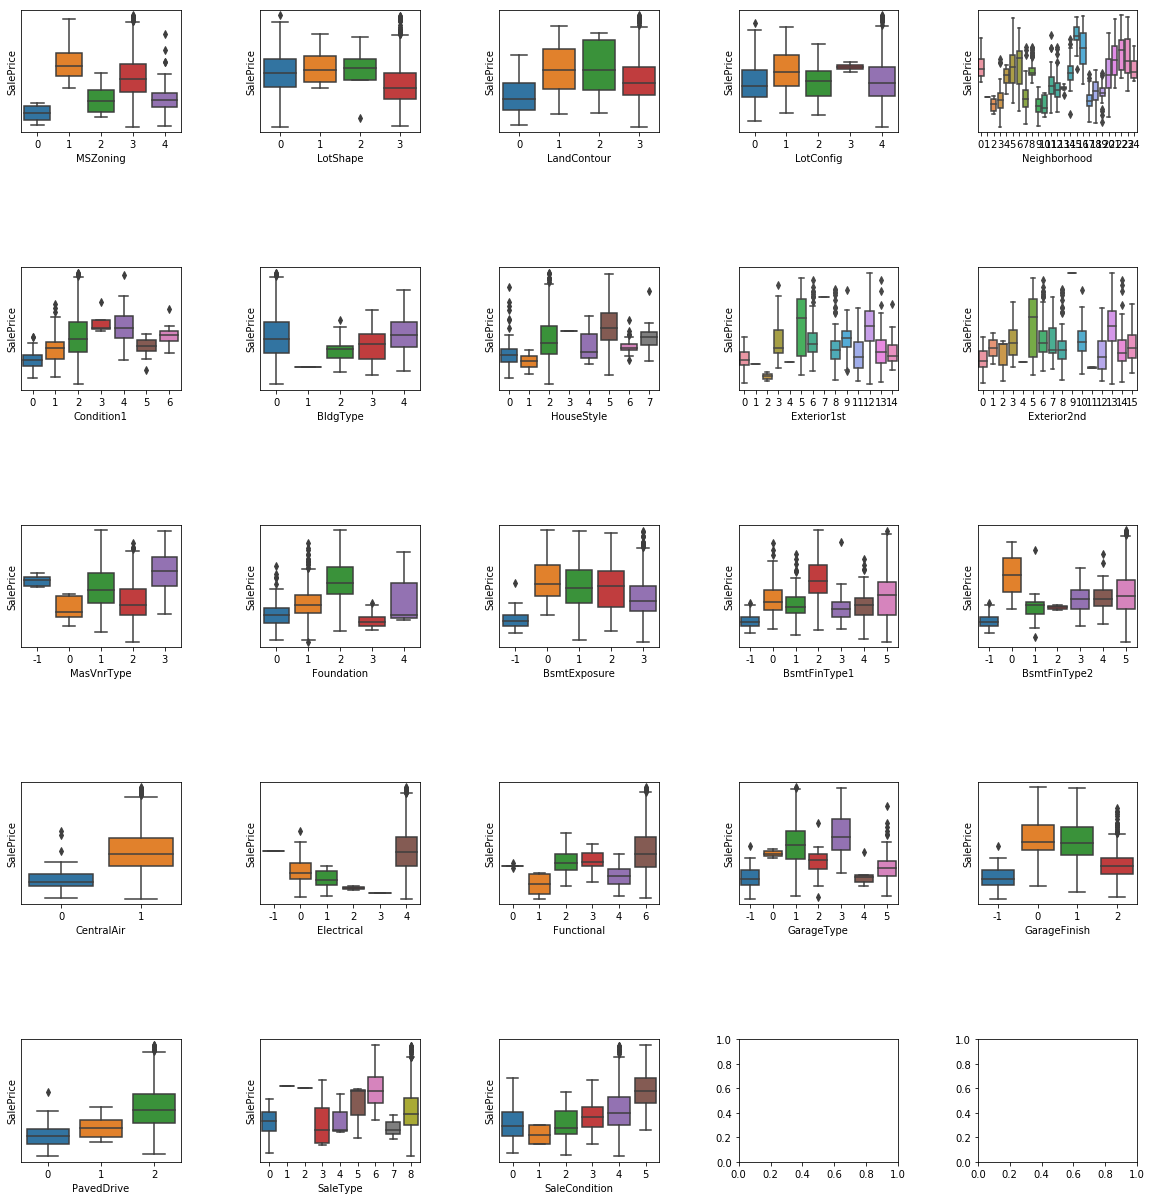

In [191]:
fig, ax = plt.subplots(figsize=(20,20), ncols= 5, nrows= int(math.ceil(len(sig_cat) / 5) +1))

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .5     # the amount of width reserved for blank space between subplots
hspace =  1.1    # the amount of height reserved for white space between subplots

plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

cat_train = no_outliers_train[sig_cat]
c = 0
for i in range(int(math.ceil(len(sig_cat) / 5) +1)):
    for j in range(5):
        if c < len(sig_cat):
            sns.boxplot(cat_train.iloc[:, c], no_outliers_train.loc[:,'SalePrice'], ax=ax[i][j])
            #ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            c= c  + 1

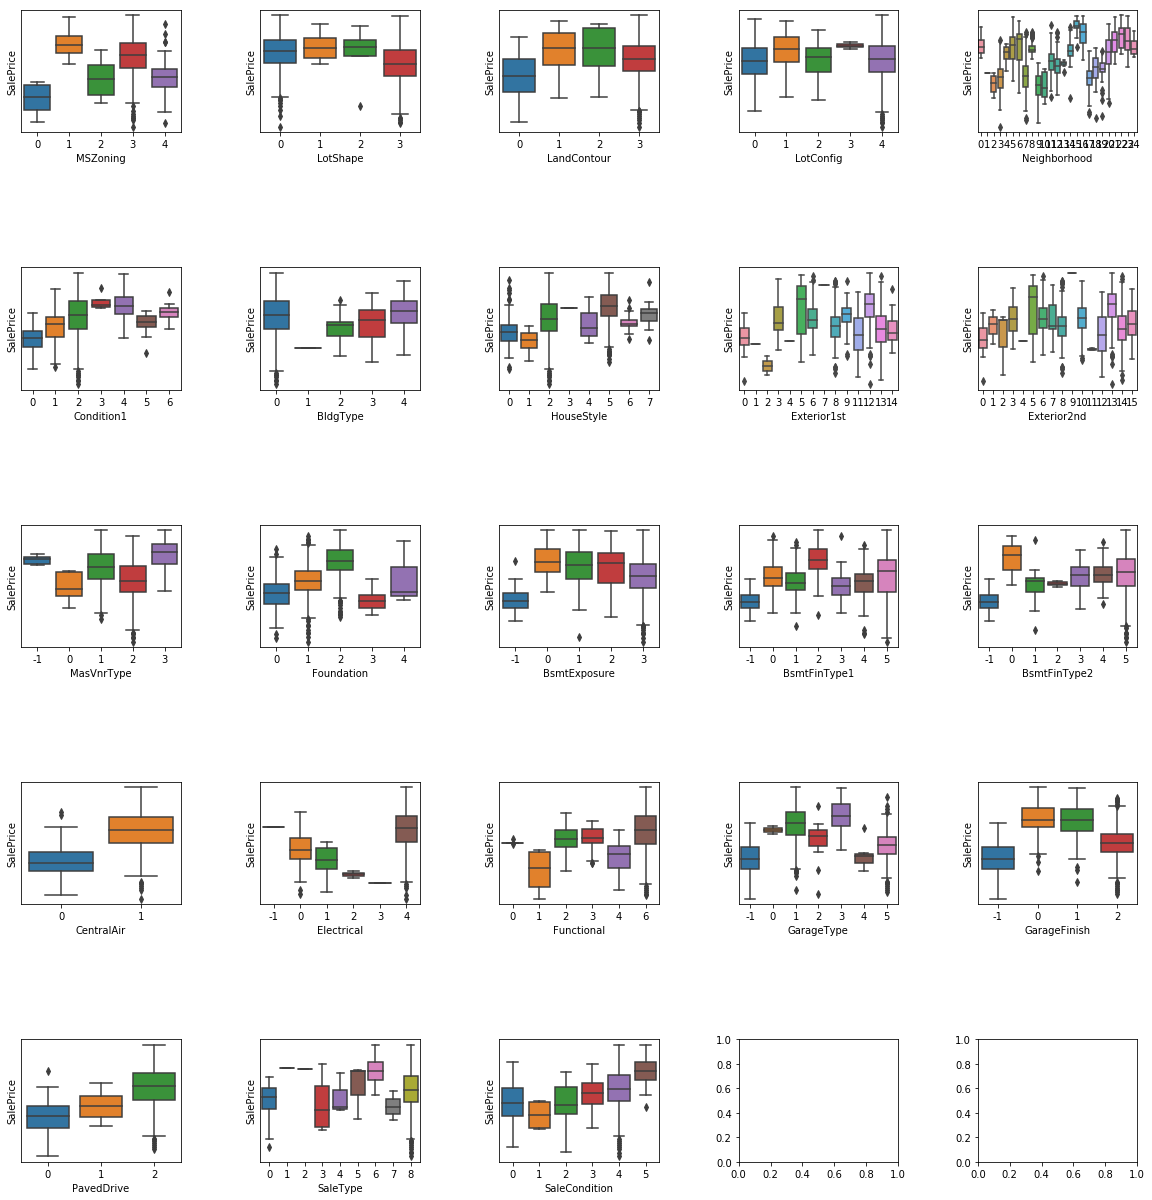

In [192]:
fig, ax = plt.subplots(figsize=(20,20), ncols= 5, nrows= int(math.ceil(len(sig_cat) / 5) +1))

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .5     # the amount of width reserved for blank space between subplots
hspace =  1.1    # the amount of height reserved for white space between subplots

plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

cat_train = no_outliers_train_log[sig_cat]
c = 0
for i in range(int(math.ceil(len(sig_cat) / 5) +1)):
    for j in range(5):
        if c < len(sig_cat):
            sns.boxplot(cat_train.iloc[:, c], no_outliers_train_log.loc[:,'SalePrice'], ax=ax[i][j])
            #ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            c= c  + 1

In [205]:
cat_train = no_outliers_train[sig_cat].astype(str)
cat_train = pd.get_dummies(cat_train)
num_train = no_outliers_train[new_sig_num]
ord_train = no_outliers_train[sig_ordinal]
total= pd.concat([cat_train, num_train, ord_train , no_outliers_train['SalePrice']], axis = 1)
total_log = pd.concat([cat_train, no_outliers_train_log[new_sig_num], ord_train , no_outliers_train_log['SalePrice']], axis = 1)

In [206]:
cat_test = test[sig_cat].astype(str)
cat_test = pd.get_dummies(cat_test)
num_test= test[new_sig_num]
ord_test = test[sig_ordinal]
num_test_log = np.log(test[new_sig_num]+1)
total_test= pd.concat([cat_test, num_test, ord_test], axis = 1)
total_test_log= pd.concat([cat_test, num_test_log, ord_test], axis = 1)

In [207]:
common_col = list(set(total.columns.values).intersection(set(total_test.columns.values)))
total_test = total_test[common_col]
total = total[common_col + ['SalePrice']]
total_test_log = total_test_log[common_col]
total_log = total_log[common_col + ['SalePrice']]

In [212]:
X = total.iloc[:,:-1]
y = total['SalePrice']
X_log = total_log.iloc[:,:-1]
y_log = total_log['SalePrice']

In [213]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
gbr = GradientBoostingRegressor(n_estimators=100)

# Prediction
parameters = {'min_samples_leaf':[5,10,20,40],
             'learning_rate' : [.01,.1,1] }


gbr_estimator = GridSearchCV(gbr,parameters, cv=10, scoring= 'mean_squared_error')
gbr_estimator_reg = gbr_estimator.fit(X, y)
gbr_estimator_log = gbr_estimator.fit(X_log, y_log)

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

In [214]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor()
parameters = {'learning_rate' : [.01,.1,1],
             'n_estimators':[50,100,200,400]}
ada_estimator = GridSearchCV(ada ,parameters, cv=10, scoring= 'mean_squared_error')

ada_estimator_reg = ada_estimator.fit(X, y)
ada_estimator_log = ada_estimator.fit(X_log, y_log)
#ada_estimator.best_params_

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

In [215]:
from sklearn import linear_model
lr = linear_model.Lasso()
parameters = {'alpha':[.001, .01, .1, 1]}

lr_estimator = GridSearchCV(lr ,parameters, cv=10, scoring= 'mean_squared_error')

lr_estimator_reg = lr_estimator.fit(X, y)
lr_estimator_log = lr_estimator.fit(X_log, y_log)
#lr_estimator.best_params_

/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda2/lib/python2.7/site-packages/sklearn/m

In [218]:
print gbr_estimator.best_params_
print gbr_estimator_log.best_params_
print ada_estimator.best_params_
print ada_estimator_log.best_params_
print lr_estimator.best_params_
print lr_estimator_log.best_params_


{'learning_rate': 0.1, 'min_samples_leaf': 20}
{'learning_rate': 0.1, 'min_samples_leaf': 20}
{'n_estimators': 400, 'learning_rate': 1}
{'n_estimators': 400, 'learning_rate': 1}
{'alpha': 0.001}
{'alpha': 0.001}


In [219]:
class modeling_class:
    def __init__(self, clf, seed=0, params = None):
        self.clf = clf
    def train(self, x_train, y_train):
        return self.clf.fit(x_train.astype(float), y_train.astype(float))
    def predict(self, x_test):
        return self.clf.predict(x_test.astype(float))
    

In [221]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt

def stacking_pred(train_df, test_df, model, k):
    best_predictions = []
    best_predictions_test = []
    kf = KFold(n_splits = k)
    train_index = list(train_df.index.values)
    for m in model:
        rmse_list = []
        models = []
        for tr, te in kf.split(train_index):
            x_train = train_df.iloc[tr,:-1].astype(float)
            y_train = train_df.iloc[tr,-1].astype(float)
            x_test = train_df.iloc[te, :-1].astype(float)
            y_test = train_df.iloc[te, -1].astype(float)
            mod = modeling_class(clf = m)
            mod = mod.train(x_train, y_train)
            pred = mod.predict(x_test)
            rmse = sqrt(mean_squared_error(pred, y_test))
            rmse_list.append(rmse)
            models.append(mod)
        best_model = models[rmse_list.index(min(rmse_list))]
        best_pred = best_model.predict(train_df.iloc[:, :-1])
        best_pred_test = best_model.predict(test_df)
        best_predictions_test.append(best_pred_test)
        best_predictions.append(best_pred)
    return(best_predictions, best_predictions_test)

In [222]:
gbr = GradientBoostingRegressor(learning_rate = 0.1, min_samples_leaf=20)
ada = AdaBoostRegressor(learning_rate = 1, n_estimators= 400)
lr = linear_model.Lasso(alpha = .001)

model = [gbr, ada, lr]

In [223]:
best_predictions, best_predictions_test = stacking_pred(total, total_test, model, 5)

In [224]:
best_predictions_log, best_predictions_test_log = stacking_pred(total_log, total_test_log, model, 5)

In [252]:
t = pd.DataFrame(best_predictions)
t = t.transpose()
t.columns = ['GBR', 'ADA', 'LR']
t['SalePrice'] = list(total['SalePrice'])

In [253]:
X_train, X_test, y_train, y_test = train_test_split(t.iloc[:,:-1], t['SalePrice'], test_size=0.4, random_state=0)


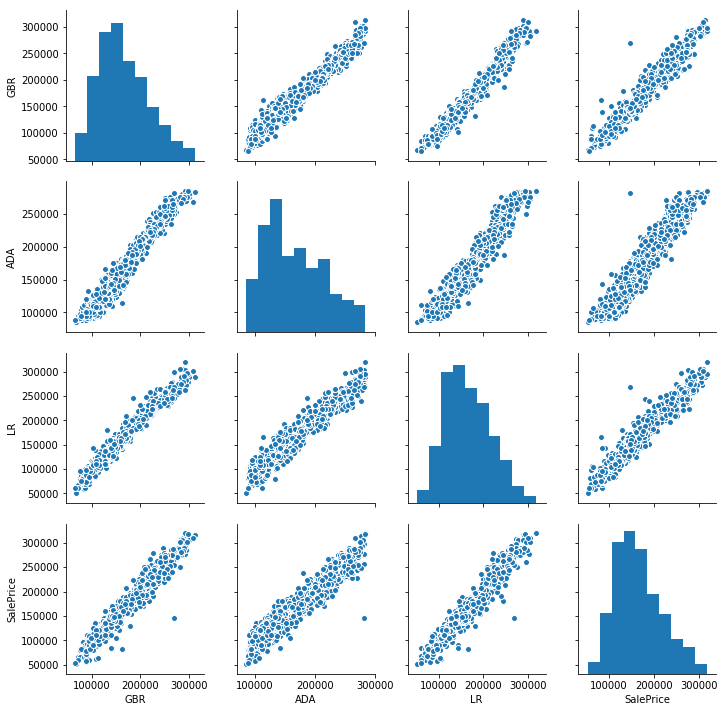

In [254]:
sns.pairplot(t)

In [279]:
t['GBR-SP'] = abs(t['GBR'] - t['SalePrice'])
t['ADA-SP'] = abs(t['ADA'] - t['SalePrice'])
t['LR-SP'] = abs(t['LR'] - t['SalePrice'])
diff = t.iloc[:,-3:].melt()
diff['x'] = list(np.arange(t.shape[0])) * 3
diff.head()

,variable,value,x
0,GBR-SP,1741.263949,0
1,GBR-SP,17052.490944,1
2,GBR-SP,119.038979,2
3,GBR-SP,21364.071905,3
4,GBR-SP,31586.452101,4


In [285]:
t_outlier = find_outliers(t.columns.values[:3], 'SalePrice', t, model = EllipticEnvelope(contamination=.05))
t = t.drop(t.index[t_outlier])


In [286]:
X_train, X_test, y_train, y_test = train_test_split(t.iloc[:,:3], t['SalePrice'], test_size=0.4, random_state=0)

lr = linear_model.Lasso(alpha = .001)



lr_fit = lr.fit(X_train, y_train)
lr_predict = lr_fit.predict(X_test)

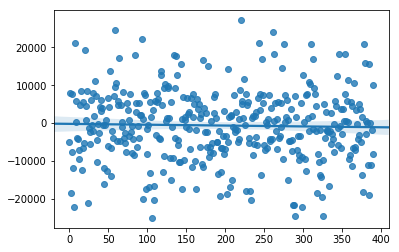

In [287]:
sns.regplot( x = np.arange(len(lr_predict)), y = (np.array(y_test) - np.array(lr_predict)) )

In [288]:
test_sub= pd.DataFrame(best_predictions_test)
test_sub = test_sub.transpose()
test_predict = lr_fit.predict(test_sub)
test_sub_df = pd.DataFrame({'Id' : test['Id'],
                          'SalePrice' : test_predict})
test_sub_df = test_sub_df.set_index('Id')
test_sub_df.to_csv('test_sub.csv')

In [290]:
test_sub_df.head()

,SalePrice
Id,
1461,140450.701222
1462,160941.332746
1463,194720.172542
1464,204838.071953
1465,188982.391020
